## Import neccessary packages ##
## 載入需要的套件 ##

In [ ]:
#用我自己的試試看
import os
import cv2
import pandas as pd
import numpy as np
from glob import glob
import tensorflow as tf
from sklearn.model_selection import train_test_split
from time import time
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

data_dir_path = './where_am_i/'
tf.keras.backend.clear_session()

### Retrieve target labels from mappings.txt file ###
### 將Target Labels 從 mappings.txt 檔案抓出來 ###

In [ ]:
#把taget labels從Mappings裡面整理出來
target_label_file_name = 'mapping.txt'
target_label_file_path = ''.join((data_dir_path,target_label_file_name))
with open(target_label_file_path) as f:
    all_lines = [line.split(', ') for line in f.read().splitlines()]
target_labels = dict()
for line in all_lines:
    target_class, target_label = line
    target_labels[target_class] = target_label

### Set training data directory ###
### 指定存放 train 資料集的資料夾 ###

In [ ]:
# 指定存放 train 資料集的資料夾
train_dir = ''.join((data_dir_path, 'train'))
img_path_list = []
img_class_list = []
for key in target_labels.keys():
    for file_path in glob('{}/{}/*.jpg'.format(train_dir, key)):
        img_class_list.append(target_labels[key])
        img_path_list.append(file_path)

data_list = pd.DataFrame({'class': img_class_list, 'path': img_path_list})

### Convert data_list into a numpy array and retrieve image data from data_list_np ###
### 把data_list轉np array 再將image資料從data_list_np抓出來 ###

In [1]:
#把data_list轉np array
data_list_np = data_list.values
data_list_np.shape

#把image資料從data_list_np抓出來
image_data=[]
for i in range(len(data_list_np)):
    #image_data.append(cv2.imread(data_list_np[i][1]))
    #image_data.append(data_list_np[i][0])
    image_temp = cv2.imread(data_list_np[i][1])
    image_temp = cv2.resize(image_temp, (224, 224))
    image_temp = cv2.cvtColor(image_temp, cv2.COLOR_BGR2RGB)
    image_data.append(image_temp)

image_data_np = np.asarray(image_data)

### Convert datatypes as necessary ###
### 做一些必要的型態轉換 ###

In [ ]:
#做一些必要的型態轉換
num_classes=15
class_label = data_list[['class']].copy()
class_label_np=class_label.values
class_label_np = class_label_np.astype(int)

### Add a channel to the image data in preparation for data augmentation ###
### 幫image data加一個channel 使得可以丟進 ImageDataGenerator 做為資料增量使用 ###

In [ ]:
#幫image data加一個channel讓可以丟進ImageDataGenerator
# image_data_np = np.expand_dims(image_data_np, axis=3)

class_label_lt=[]
for i in range(len(class_label_np)):
    class_label_lt.append(class_label_np[i][0])

### One-hot Encoding ###

In [ ]:
#one-hot-encode
class_label_OneHot = np.eye(num_classes)[class_label_lt]
#class_label_OneHot[0:5]
#class_label_OneHot.shape
X_train, X_valid, y_train, y_valid = train_test_split(image_data_np, class_label_OneHot, test_size = 0.25, stratify = class_label)

### Check training and valiadation set data ###
### 查看 Training set 與  validation set 的資料 ###

In [2]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

print('size of training data:', X_train.shape, y_train.shape)
print('size of testing data:', X_valid.shape, y_valid.shape)

(2238, 224, 224, 3)
(2238, 15)
(747, 224, 224, 3)
(747, 15)
size of training data: (2238, 224, 224, 3) (2238, 15)
size of testing data: (747, 224, 224, 3) (747, 15)


### Convert data type as necessary and scale the values ###
### 資料型態轉換以及影像大小正規化 ###

In [3]:
X_train = X_train.astype('float32')
X_valid = X_valid.astype('float32')
#Scaling the values
X_train = X_train/255.0
X_valid = X_valid/255.0

### Utilize Transfer Learning - using DenseNet201 pretrained model ###
### Transfer Learning 使用Pretrained Model - DenseNet201 ###

In [4]:
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.densenet import DenseNet201

model_name = 'DenseNet201-Fine-Tune'

img_rows, img_cols, img_channel = 224, 224, 3
base_model = DenseNet201(weights='imagenet', include_top=False,
                         input_shape=(img_rows, img_cols, img_channel))

x = base_model.output
x = GlobalAveragePooling2D(data_format='channels_last')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
74842112/74836368 [==============================] - 28s 0us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
______________________________________________________

conv4_block25_concat (Concatena (None, 14, 14, 1056) 0           conv4_block24_concat[0][0]       
                                                                 conv4_block25_2_conv[0][0]       
__________________________________________________________________________________________________
conv4_block26_0_bn (BatchNormal (None, 14, 14, 1056) 4224        conv4_block25_concat[0][0]       
__________________________________________________________________________________________________
conv4_block26_0_relu (Activatio (None, 14, 14, 1056) 0           conv4_block26_0_bn[0][0]         
__________________________________________________________________________________________________
conv4_block26_1_conv (Conv2D)   (None, 14, 14, 128)  135168      conv4_block26_0_relu[0][0]       
__________________________________________________________________________________________________
conv4_block26_1_bn (BatchNormal (None, 14, 14, 128)  512         conv4_block26_1_conv[0][0]       
__________

Total params: 18,350,799
Trainable params: 18,121,743
Non-trainable params: 229,056
__________________________________________________________________________________________________


### Set some necessary arguments Adam as optimizer, early stop atfter 5 trials. ###
### 設定一些必要的參數 用Adam 當作optimizer, 模型在訓練5次沒有進步就停止訓練 ###

In [5]:
epochs = 100
batch_size = 32
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

optimizer = keras.optimizers.Adam(lr=10e-6)

model_path = './saved_models/{}.h5'.format(model_name)

checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, metrics=['accuracy'])

batch_size = 16
model_history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = batch_size),
                                    epochs = epochs,
                                    validation_data = (X_valid, y_valid),
                                    callbacks = [checkpoint, earlystop])

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
747/747 [==============================] - 6s 8ms/sample - loss: 2.2379 - acc: 0.2758

Epoch 00001: val_loss improved from inf to 2.23789, saving model to ./saved_models/DenseNet201-Fine-Tune.h5
140/140 [==============================] - 264s 2s/step - loss: 2.7437 - acc: 0.1658 - val_loss: 2.2379 - val_acc: 0.2758
Epoch 2/100
747/747 [==============================] - 3s 4ms/sample - loss: 1.4510 - acc: 0.6037 1s 

Epoch 00002: val_loss improved from 2.23789 to 1.44945, saving model to ./saved_models/DenseNet201-Fine-Tune.h5
140/140 [==============================] - 35s 252ms/step - loss: 1.8045 - acc: 0.4147 - val_loss: 1.4494 - val_acc: 0.6037
Epoch 3/100
747/747 [==============================] - 3s 4ms/sample - loss: 0.9471 - acc: 0.7697

Epoch 00003: val_loss improved from 1.44945 to 0.94540, saving model to ./saved_models/DenseNet201-Fine-Tune.h5
140/140 [==============================] - 36s 254ms/step - loss: 1.2777 

747/747 [==============================] - 3s 4ms/sample - loss: 0.1544 - acc: 0.9478

Epoch 00025: val_loss did not improve from 0.14907
140/140 [==============================] - 34s 244ms/step - loss: 0.1050 - acc: 0.9741 - val_loss: 0.1539 - val_acc: 0.9478
Epoch 26/100
747/747 [==============================] - 3s 4ms/sample - loss: 0.1581 - acc: 0.9451

Epoch 00026: val_loss did not improve from 0.14907
140/140 [==============================] - 34s 241ms/step - loss: 0.1020 - acc: 0.9723 - val_loss: 0.1576 - val_acc: 0.9451
Epoch 27/100
747/747 [==============================] - 3s 4ms/sample - loss: 0.1552 - acc: 0.9465

Epoch 00027: val_loss did not improve from 0.14907
140/140 [==============================] - 33s 239ms/step - loss: 0.0840 - acc: 0.9781 - val_loss: 0.1544 - val_acc: 0.9465
Epoch 28/100
747/747 [==============================] - 3s 4ms/sample - loss: 0.1709 - acc: 0.9398 1s -

Epoch 00028: val_loss did not improve from 0.14907
140/140 [=======================

### Look at the learning curve ###
### 觀察學習曲線 ###

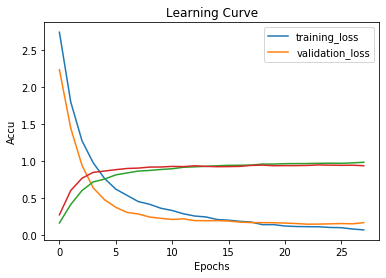

In [6]:
#自己的畫圖
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
training_acc = model_history.history['acc']
val_acc = model_history.history['val_acc']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')

plt.plot(training_acc, label="training_acc")
plt.plot(val_acc, label="validation_acc")
plt.xlabel('Epochs')
plt.ylabel("Accu")
plt.title('Learning Curve')


plt.show()

### Testing data preprocessing ###
### Testing 資料的前處理 ###

In [7]:
from pathlib import Path,PurePosixPath
# Assing test data library
test_dir = ''.join((data_dir_path, 'testset/'))
test_img_path_list = []
for test_file_path in sorted(Path(test_dir).glob('*.jpg')):
    test_img_path_list.append(test_file_path)

#convert Posix obj to str
test_img_path_str = []
for i in range(len(test_img_path_list)):
    test_img_path_str.append(test_img_path_list[i].as_posix())

test_img_path_str_np = np.asarray(test_img_path_str)

test_str=[]
import re
for i in range(len(test_img_path_str)):
    test_str.append(re.findall("([A-Za-z0-9]+.jpg)",test_img_path_str[i]))

fullStr = ''.join([str(elem) for elem in test_str ])
fullStr_step1=fullStr.replace('\'][\'','')
fullStr_step2=fullStr_step1.replace('[\'','')
fullStr_step3=fullStr_step2.replace(']\'','')

test_path_id=''
for element in fullStr_step3:
    test_path_id+=element
id_test_list=test_path_id.split('.jpg') #.jpg
print(id_test_list[0])
#del id_test_list[-1]

id_test_list.pop(1500)

final_id_list=pd.DataFrame(id_test_list)

001d4c8d70ebf7f025fccf256324d3d5ad3560faee1cdf8c7115f5eb033bc3d2


In [8]:
test_list = pd.DataFrame({'path': test_img_path_str_np})

test_list.head(10)

test_list_np = test_list.values
test_list_np.shape

test_data=[]
for i in range(len(test_list_np)):
    testlist_temp = cv2.imread(test_list_np[i][0])
    testlist_temp = cv2.resize(testlist_temp, (224, 224))
    testlist_temp = cv2.cvtColor(testlist_temp, cv2.COLOR_BGR2RGB)
    test_data.append(testlist_temp)

test_data_np = np.asarray(test_data)
test_data_np.shape

# test_data_np = np.expand_dims(test_data_np, axis=3)
# test_data_np.shape

(1500, 224, 224, 3)

In [9]:
X_test = test_data_np
X_test = X_test / 255.0
X_test = X_test.astype('float32')

model = load_model(model_path)

scores = model.evaluate(X_valid, y_valid, verbose=1)
print('Validation loss:', scores[0])
print('Validation accuracy:', scores[1])

747/747 [==============================] - 6s 8ms/sample - loss: 0.1496 - acc: 0.9438 12s - loss: 
Validation loss: 0.1495757032849064
Validation accuracy: 0.9437751


### Convert and export in as a csv file for upload ###
### 輸出成 csv檔案 ###

In [10]:
X_id = id_test_list
y_test_pred_prob = model.predict(X_test)
y_test_pred = y_test_pred_prob.argmax(axis=-1)
y_test_pred_df = pd.DataFrame({'id': np.array(X_id), 'class':y_test_pred}).sort_values(by='id')
y_test_pred_df.to_csv('{}.csv'.format(model_name), index=False)